# Convolutional Neural Network (CNN) Training

This training is based upon existing [courses](https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c04_exercise_flowers_with_data_augmentation_solution.ipynb) and [tutorials on classification](https://www.tensorflow.org/tutorials/images/classification) and [transfer learning](https://www.tensorflow.org/tutorials/images/transfer_learning).

In [1]:
# System modules
import logging
import os
import shutil
from glob import glob

# Math modules
import numpy as np

# Machine-learning modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from sklearn.model_selection import train_test_split
from augment_data import augment_images

# Plotting Modules
import matplotlib.pyplot as plt
%matplotlib inline

# Logging Configuration
logging.basicConfig(level=logging.INFO,
                    format='%(name)s\t[%(levelname)-8s] %(message)s')
logger = logging.getLogger('CNN')

logger.info('Tensorflow Version: %s' % tf.__version__)

CNN	[INFO    ] Tensorflow Version: 2.1.0


In [2]:
# Define classes
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Data Preprocessing
Execute this Code only once because it will move the data into a new training and validation directory:

In [4]:
# Load images
cwd = os.getcwd() # current working directory
base_dir = os.path.join(cwd, 'img') # base image directory
for cl in classes:
    img_path = os.path.join(base_dir, 'original-jpegs', cl)
    logger.debug('img_path: %s', img_path)
    images = glob(img_path + '/*.jpg')
    logger.info("%s:\t%s Images" % (cl, len(images)))

    # Split images into train an validation
    train, val = train_test_split(images, test_size=.2)

    # Move images into training directory
    for t in train:
        if not os.path.exists(os.path.join(base_dir, 'train', cl)):
            os.makedirs(os.path.join(base_dir, 'train', cl))
        shutil.move(t, os.path.join(base_dir, 'train', cl))

    # Move images into validation directory
    for v in val:
        if not os.path.exists(os.path.join(base_dir, 'val', cl)):
            os.makedirs(os.path.join(base_dir, 'val', cl))
        shutil.move(v, os.path.join(base_dir, 'val', cl))

CNN	[INFO    ] img_path: E:\repositories\flowers\img\original-jpegs\daisy
CNN	[INFO    ] daisy:	633 Images
CNN	[INFO    ] img_path: E:\repositories\flowers\img\original-jpegs\dandelion
CNN	[INFO    ] dandelion:	898 Images
CNN	[INFO    ] img_path: E:\repositories\flowers\img\original-jpegs\roses
CNN	[INFO    ] roses:	641 Images
CNN	[INFO    ] img_path: E:\repositories\flowers\img\original-jpegs\sunflowers
CNN	[INFO    ] sunflowers:	699 Images
CNN	[INFO    ] img_path: E:\repositories\flowers\img\original-jpegs\tulips
CNN	[INFO    ] tulips:	799 Images


In [3]:
cwd = os.getcwd() # current working directory
base_dir = os.path.join(cwd, 'img') # base image directory
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

## Show the (augmented) images
Geting an image generator with default settings (rotation, transformation, etc.) and plot 10 example images.

Found 2934 images belonging to 5 classes.


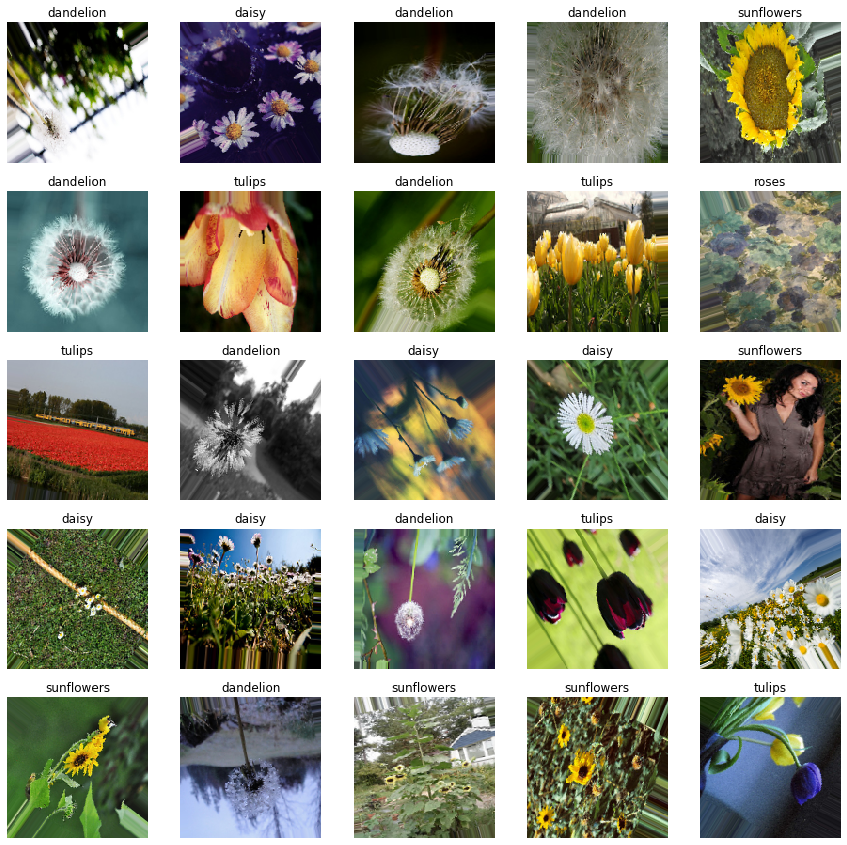

<Figure size 432x288 with 0 Axes>

In [45]:
batch_size = 25
img_height, img_width = 150, 150
IMG_SHAPE=(img_height, img_width, 3)

train_image_generator = augment_images(train_dir, 
        batch_size=batch_size,
        output_shape=(img_height, img_width),
        rotation_range=45,
        width_shift_range=.1,
        height_shift_range=.1,
        zoom_range=.1,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1./255)
batch_image, batch_type = next(train_image_generator)

fig = plt.figure(figsize=(15,15))
for i in range(batch_size):
    plt.subplot(5,5,i+1)
    image, type = batch_image[i,:,:,:], batch_type[i]
    plt.imshow(image)
    plt.title(classes[int(type)])
    plt.axis('off')
plt.show()
plt.savefig('output/augmented_data.png')

# Define Model
Using a deep neural network as model ([Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) with multiple [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

The convolutional filters are all using the "SAME" padding and [ReLu](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu) [activation function](https://www.tensorflow.org/api_docs/python/tf/keras/activations).

Layers in detail:
1. Convolutional Part
  1. 16 basic (3 x 3) convolutional filters (Conv2D layer) with a ReLu activation function
  2. (2 x 2) MaxPooling2D layer with a ReLu activation function.
2. [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer to randomly drop 20% of the activated neurons (during training only).
3. Convolutional Part
  1. 32 (3 x 3) Conv2D layer with a ReLu activation function for more detailed features.
  2. (2 x 2) MaxPooling2D layer with a ReLu activation function.
3. Convolutional Part
  1. 64 (3 x 3) Conv2D layer with a ReLu activation function for complex features.
  2. (2 x 2) MaxPooling2D layer with a ReLu activation function.
8. [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer to randomly drop 20% of the activated neurons (during training only).
9. [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) layer just flattens the 2D image (3D with colors) into a 1D list.
10. [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with 512 connected neurons
11. [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer to randomly drop 20% of the activated neurons (during training only).
12. [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) output layer with 5 connected neurons and a [softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) activation function.



In [7]:
model = Sequential([
            Conv2D(16, 3, padding='same', activation='relu', input_shape=IMG_SHAPE),
            MaxPooling2D(),
            Dropout(0.2),
            Conv2D(32, 3, padding='same', activation='relu'),
            MaxPooling2D(),
            Conv2D(64, 3, padding='same', activation='relu'),
            MaxPooling2D(),
            Dropout(0.2),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.2),
            Dense(5, activation='softmax')
            ])

Compile the model using the **optimizer** [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) (short for adaptive moment estimation, [Source](https://arxiv.org/abs/1412.6980)).
It is updating the weigths adaptively ... **TODO: Explain more**

As **loss function** the [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) calculates the cross entropy between the categories (*"Using from_logits=True is more numerically stable"* [Source](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)). **TODO: Explain more**


Evaluating the model by calculating the [`accuracy`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy) **TODO: Move to evaluating model**

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

# Train model

In [9]:
batch_size = 128

train_data_gen = augment_images(train_dir, 
                                batch_size, 
                                output_shape=(img_height, img_width),
        width_shift_range=.1,
        height_shift_range=.1,
        zoom_range=.1,
)
val_data_gen = augment_images(val_dir, 
                              batch_size, 
                              output_shape=(img_height, img_width),
        width_shift_range=.1,
        height_shift_range=.1,
        zoom_range=.1,
        )

total_train = train_data_gen.samples
total_val = val_data_gen.samples

Found 2934 images belonging to 5 classes.
Found 736 images belonging to 5 classes.


In [10]:
epochs = 15
history = model.fit(
    train_data_gen,
    steps_per_epoch=1 + total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=1 + total_val // batch_size
)

  ...
    to  
  ['...']


tensorflow	[WARNING ] sample_weight modes were coerced from
  ...
    to  
  ['...']


  ...
    to  
  ['...']


tensorflow	[WARNING ] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 23 steps, validate for 6 steps
Epoch 1/15
23/23 [==============================] - 126s 5s/step - loss: 1.6608 - accuracy: 0.2386 - val_loss: 1.6587 - val_accuracy: 0.2446
Epoch 2/15
23/23 [==============================] - 112s 5s/step - loss: 1.6601 - accuracy: 0.2447 - val_loss: 1.6587 - val_accuracy: 0.2446
Epoch 3/15
23/23 [==============================] - 128s 6s/step - loss: 1.6601 - accuracy: 0.2447 - val_loss: 1.6587 - val_accuracy: 0.2446
Epoch 4/15
23/23 [==============================] - 109s 5s/step - loss: 1.6601 - accuracy: 0.2447 - val_loss: 1.6587 - val_accuracy: 0.2446
Epoch 5/15
23/23 [==============================] - 95s 4s/step - loss: 1.6601 - accuracy: 0.2447 - val_loss: 1.6587 - val_accuracy: 0.2446
Epoch 6/15
23/23 [==============================] - 83s 4s/step - loss: 1.6601 - accuracy: 0.2447 - val_loss: 1.6587 - val_accuracy: 0.2446
Epoch 7/15
23/23 [==============================] - 80s 3s/step - loss: 1.6600 - accuracy: 0.2447 - val_loss: 1.658

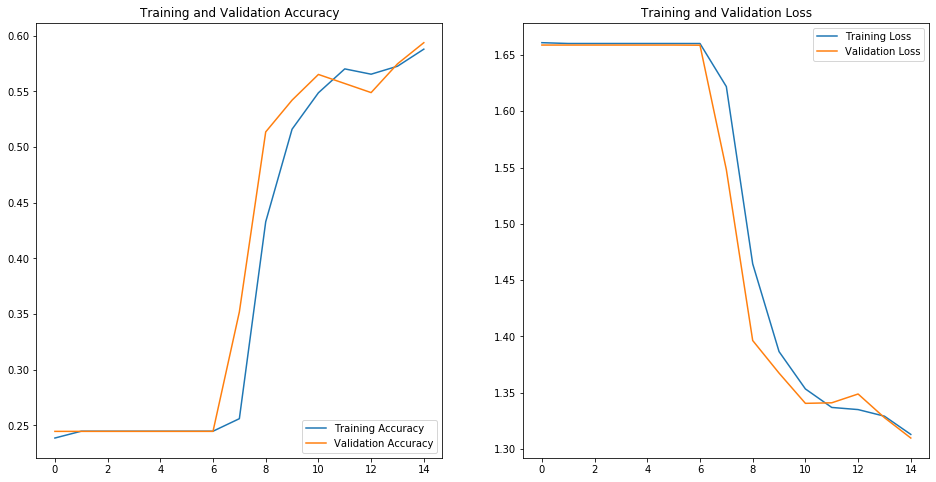

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('output/own_model_training.png')

# Show some predictions

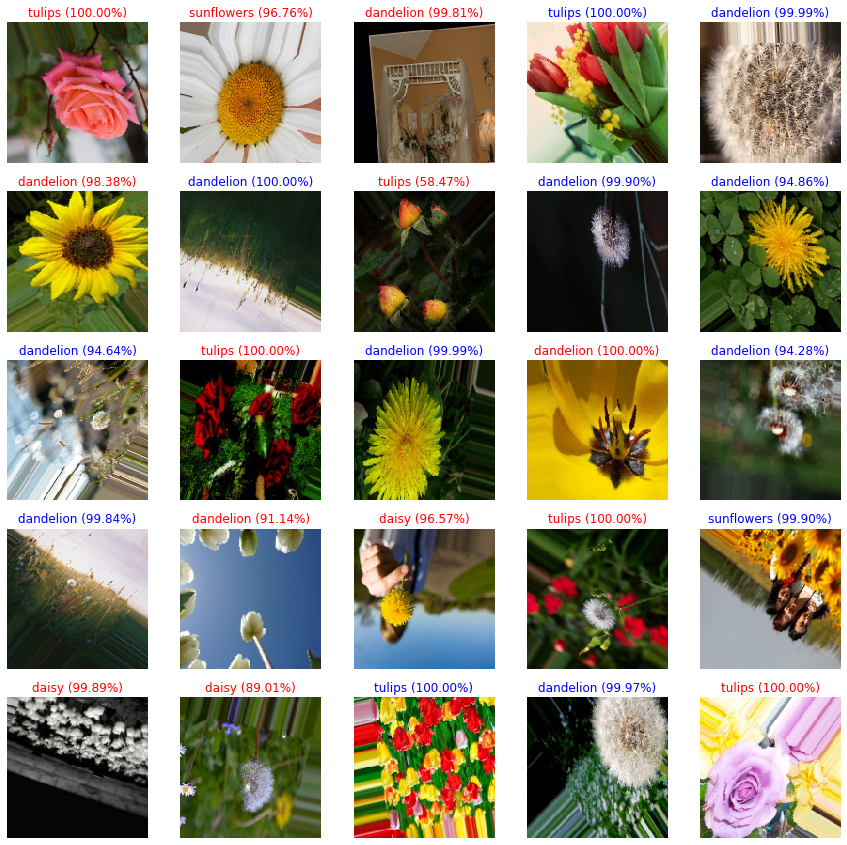

<Figure size 432x288 with 0 Axes>

In [44]:
fig = plt.figure(figsize=(15,15))

data = next(val_data_gen)
y_pred = model.predict(data, batch_size)
for i in range(25):
    plt.subplot(5,5,i+1)
    image, typ = data[0][i,:,:,:], data[1][i]
    plt.imshow(image)
    prediction = np.argmax(y_pred[i,:])
    color = "blue" if prediction == int(typ) else "red"
    plt.title("%s (%.2f%s)" % (classes[prediction], 
                                100*y_pred[i,prediction], 
                                '%'),
                 color=color)
    plt.axis('off')
plt.show()
plt.savefig('output/cnn_model_predictions.png')

# Save the model

In [21]:
model.save('output/cnn_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


tensorflow	[WARNING ] From C:\Users\JP\Miniconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: cnn_model.tf\assets


tensorflow	[INFO    ] Assets written to: cnn_model.tf\assets


# Compare with pre-trained model
Creating a second model derived from [ImageNet](http://image-net.org/) pre trained neural nets.

C:\Users\JP\Miniconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,230,277
Non-trainable params: 34,112
_________________________________________________________________
Found 2934 images belonging to 5 classes.
Found 736 images belonging to 5 classes.
  ...
    to  
  ['...']


tensorflow	[WARNING ] sample_weight modes were coerced from
  ...
    to  
  ['...']


  ...
    to  
  ['...']


tensorflow	[WARNING ] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 30 steps, validate for 8 steps
Epoch 1/15
30/30 [==============================] - 78s 3s/step - loss: 1.3118 - accuracy: 0.5876 - val_loss: 1.3323 - val_accuracy: 0.5598
Epoch 2/15
30/30 [==============================] - 92s 3s/step - loss: 1.3075 - accuracy: 0.5883 - val_loss: 1.3037 - val_accuracy: 0.6019
Epoch 3/15
30/30 [==============================] - 72s 2s/step - loss: 1.2989 - accuracy: 0.6012 - val_loss: 1.3118 - val_accuracy: 0.5924
Epoch 4/15
30/30 [==============================] - 75s 3s/step - loss: 1.2992 - accuracy: 0.6012 - val_loss: 1.3212 - val_accuracy: 0.5734
Epoch 5/15
30/30 [==============================] - 82s 3s/step - loss: 1.2876 - accuracy: 0.6108 - val_loss: 1.3170 - val_accuracy: 0.5842
Epoch 6/15
30/30 [==============================] - 75s 3s/step - loss: 1.2894 - accuracy: 0.6091 - val_loss: 1.3590 - val_accuracy: 0.5435
Epoch 7/15
30/30 [==============================] - 63s 2s/step - loss: 1.2958 - accuracy: 0.6029 - val_loss: 1.3316 - 

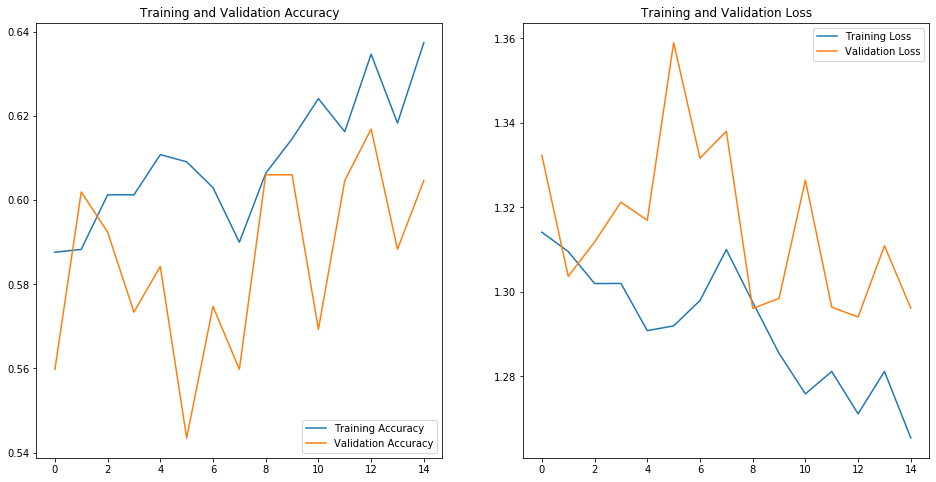

INFO:tensorflow:Assets written to: cnn_model_imagenet.tf\assets


tensorflow	[INFO    ] Assets written to: cnn_model_imagenet.tf\assets


<Figure size 432x288 with 0 Axes>

In [29]:
batch_size = 100
img_height, img_width = 150, 150
IMG_SHAPE=(img_height, img_width, 3)

imagenet = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')
model2 = Sequential([
            imagenet,
            tf.keras.layers.GlobalAveragePooling2D(),
            Dropout(0.2),
            Dense(5, activation='softmax')
            ])
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',])
model2.summary()

train_data_gen = augment_images(train_dir, 
                                batch_size, 
                                output_shape=(img_height, img_width),
                                )
val_data_gen = augment_images(val_dir, 
                              batch_size, 
                              output_shape=(img_height, img_width),
                              )

epochs = 15
history = model.fit(
    train_data_gen,
    steps_per_epoch=1 + train_data_gen.n // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=1 + val_data_gen.n // batch_size
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('output/imagenet_model_training.png')

model.save('output/cnn_model_imagenet')